In [3]:
import pandas as pd
import math
from scipy.spatial import ConvexHull
import numpy as np

In [9]:
df = pd.read_csv("../data/data-ny.csv", sep = ',', header=None, names =  ['userid', 'venueid', 'venuecatid', 'venuecatname','latitude','longitude','timezone','utctime'])
category = "Coffee Shop"
venueid = '4ab966c3f964a5203c7f20e3'
user = 642
time = 16

In [10]:
users = pd.DataFrame({'count' : df.groupby(['userid']).size()}).reset_index()
# users = df['userid'].unique()
# print(users[0])
#user_rows = df.loc[df['userid'] == users['userid'][0]]
print(users[1:2].userid)

1    2
Name: userid, dtype: int64


In [11]:
category_rows = df.loc[df['venuecatname'] == category]

In [12]:
user_rows = df.loc[df['userid'] == user]
print(user_rows.head())

      userid                   venueid                venuecatid  \
6        642  4ab966c3f964a5203c7f20e3  4bf58dd8d48988d1e0931735   
26       642  4d9a2f78d97ba1430b43336b  4bf58dd8d48988d130941735   
3912     642  4a4ff7a8f964a520ddaf1fe3  4bf58dd8d48988d163941735   
4224     642  4bdf41600ee3a593bc8233b0  4bf58dd8d48988d164941735   
4485     642  4b4cd551f964a520c8c026e3  4bf58dd8d48988d1f6941735   

          venuecatname   latitude  longitude  timezone  \
6          Coffee Shop  40.751591 -73.974121      -240   
26            Building  40.752307 -73.971854      -240   
3912              Park  40.647792 -74.003735      -240   
4224             Plaza  40.632220 -73.947299      -240   
4485  Department Store  40.631544 -73.946874      -240   

                             utctime  
6     Tue Apr 03 18:04:38 +0000 2012  
26    Tue Apr 03 18:14:21 +0000 2012  
3912  Sat Apr 07 19:40:16 +0000 2012  
4224  Sat Apr 07 22:02:45 +0000 2012  
4485  Sun Apr 08 00:15:00 +0000 2012  


In [130]:
user = pd.DataFrame({'count' : df.groupby(['userid']).size()}).reset_index()
print(len(user))

venue = pd.DataFrame({'count' : df.groupby(['venueid']).size()}).reset_index()
print(len(venue))

avg = len(venue) / len(user)
print(avg)

1083
38333
35.395198522622344


In [13]:
user_venue_group = pd.DataFrame({'count' : category_rows.groupby(['userid','venueid', 'latitude', 'longitude']).size()}).reset_index()
print(user_venue_group.head())

   userid                   venueid   latitude  longitude  count
0       1  3fd66200f964a52048e81ee3  40.785889 -73.976859      1
1       1  49d2b43ef964a520cb5b1fe3  40.720087 -74.003961      7
2       2  42829c80f964a52025221fe3  40.765901 -73.963434      1
3       2  49c64908f964a52030571fe3  40.737189 -74.001278      1
4       2  4a1c91b1f964a520527b1fe3  40.737194 -73.996536      1


In [14]:
venue_checkins = pd.DataFrame({'count' : category_rows.groupby(['venueid', 'latitude', 'longitude']).size()}).reset_index()
print(venue_checkins.head())

                    venueid   latitude  longitude  count
0  3fd66200f964a52048e81ee3  40.785889 -73.976859      4
1  3fd66200f964a52048e81ee3  40.785896 -73.976871      9
2  3fd66200f964a52052e61ee3  40.729684 -73.999758      5
3  3fd66200f964a52059e61ee3  40.729469 -74.001852      8
4  3fd66200f964a5205dee1ee3  40.716582 -73.959020      2


In [15]:
venue_user = dict()
for row in user_venue_group.iterrows():
    if row[1].venueid in venue_user:
        s = set()
        s = venue_user[row[1].venueid]
        s.add(row[1].userid)
        venue_user[row[1].venueid] = s
    else:
        s = set()
        s.add(row[1].userid)
        venue_user[row[1].venueid] = s

In [16]:
dict(list(venue_user.items())[0:2])

{'3fd66200f964a52048e81ee3': {1,
  66,
  68,
  350,
  388,
  397,
  578,
  732,
  929,
  953,
  1031,
  1039},
 '49d2b43ef964a520cb5b1fe3': {1, 372, 778, 944, 1059}}

In [17]:
alpha = {
    'food': 1.64,
    'nightlife': 1.61,
    'travel': 2.22,
    'work': 1.62,
    'home': 1.62,
    'shops': 1.64,
    'entertainment': 1.64,
    'art': 1.64,
    'parks': 1.68,
    'education': 1.96
}
print(alpha)

{'food': 1.64, 'nightlife': 1.61, 'travel': 2.22, 'work': 1.62, 'home': 1.62, 'shops': 1.64, 'entertainment': 1.64, 'art': 1.64, 'parks': 1.68, 'education': 1.96}


In [18]:
def center_of_mass(users, df):
    avg_lat = []
    avg_long = []
    _users = users
    for index, row in _users.iterrows():
        user_rows = df.loc[df['userid'] == row['userid']]
        avg_lat.append(pd.DataFrame.mean(user_rows['latitude']))
        avg_long.append(pd.DataFrame.mean(user_rows['longitude']))
    print(avg_lat[:5])
    _users['latitude'] = avg_lat
    _users['longitude'] = avg_long
    return _users
x = center_of_mass(users, df)

[40.74589812907635, 40.679839959588286, 40.744951161656495, 40.79930458308207, 40.72354518816442]


In [19]:
print(x['latitude'][0])

40.74589812907635


In [20]:
def get_lat_long(venueid, venue_checkins):
    row = venue_checkins.loc[venue_checkins['venueid'] == venueid ]
    #print(row)
    return row['latitude'], row['longitude']
y,z = get_lat_long(venueid, venue_checkins)
print(y)
print(z)

279    40.751591
Name: latitude, dtype: float64
279   -73.974121
Name: longitude, dtype: float64


In [21]:
def haversine_dist(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance between two geo co-ordiantes."""
    radius = 3959  # miles
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

In [168]:

#x = center_of_mass(user_rows)
y,z = get_lat_long(venueid, venue_checkins)
dist = []
for row in range(0,len(x)):
    dist.append(haversine_dist(x['latitude'][row], x['longitude'][row], y, z))
print(dist)

[0.5010609306450423, 4.989390117262107, 0.620337056234979, 3.507234114781406, 3.641551286036376, 1.1360029675933199, 2.0616705504311987, 1.4309164277043376, 1.492799092893405, 0.4490103872827514, 1.5254987771322124, 5.603522359404577, 11.520154994052213, 1.031691072711047, 0.5615719067720613, 7.614930227493544, 6.751007469977709, 2.8373825780540276, 3.04432538949344, 6.7784525721693605, 0.17873728465223815, 1.2300074670405385, 1.1170346572684464, 2.4079741812006943, 1.1616336211971359, 9.637842922183129, 6.848893997040429, 3.742131936293176, 5.334468084320877, 2.7074321340556895, 3.6924535190284424, 2.556690033775803, 2.9585738138904945, 3.3928162260266705, 3.890556346109203, 2.099146401381359, 1.0828737236033612, 5.560680109926139, 2.019479419673686, 5.479486643959261, 5.694990794300882, 3.0956038981098444, 7.291692055946129, 11.94457352898513, 1.1294984133474693, 3.862690705654805, 0.8456534178595392, 2.086554419241373, 3.4205464441806077, 2.965543270422917, 1.6898445186058375, 1.141

In [22]:
p_close = [1 / x ** 1.64 for x in dist]

NameError: name 'dist' is not defined

In [109]:
from sklearn.cluster import DBSCAN
data = user_rows[['latitude', 'longitude']]
db = DBSCAN(eps = 0.02, min_samples = 5, metric = 'haversine').fit(data)

In [110]:
len(data)

299

In [111]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

In [112]:
db.core_sample_indices_

array([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 18

In [113]:
labels

array([ 0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [114]:
print(len(labels))
print(len(data))

299
299


In [115]:
n_clusters_

1

In [124]:
data.drop('labels', axis =1)
data.is_copy = False
data['labels'] = labels
# data = data.loc[data['labels'] == 0]
print(data.head())
print(len(data))

       latitude  longitude  labels
6     40.751591 -73.974121       0
26    40.752307 -73.971854       0
3912  40.647792 -74.003735       0
4224  40.632220 -73.947299       0
4485  40.631544 -73.946874       0
299


In [117]:
unique_labels

{-1, 0}

In [118]:
location = np.array(user_rows[['latitude', 'longitude']])
hull = ConvexHull(location)

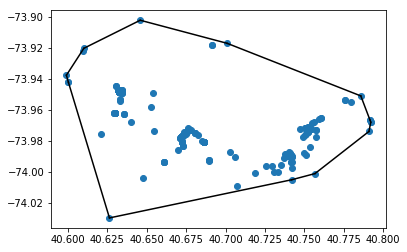

In [119]:
#import matplotlib.pyplot as plt
plt.plot(location[:,0], location[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(location[simplex, 0], location[simplex, 1], 'k-')
plt.show()

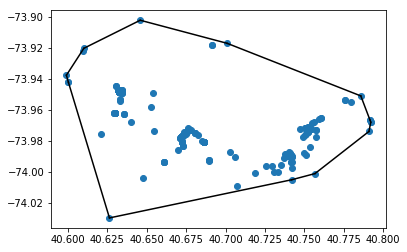

In [123]:
location = np.array(data[['latitude', 'longitude']])
hull = ConvexHull(location)
#import matplotlib.pyplot as plt
plt.plot(location[:,0], location[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(location[simplex, 0], location[simplex, 1], 'k-')
plt.show()